In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
df = pd.read_csv("../data/gold_prices.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [3]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,428.700012,431.000000,431.000000,431.000000,4
2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2005-01-05,426.600006,425.700012,425.700012,425.700012,2
2005-01-06,421.000000,421.000000,421.000000,421.000000,1
2005-01-07,418.899994,423.700012,418.700012,423.700012,1
...,...,...,...,...,...
2025-09-24,3732.100098,3772.500000,3732.100098,3769.800049,588
2025-09-25,3736.899902,3756.000000,3724.699951,3742.800049,1899
2025-09-26,3775.300049,3775.300049,3775.300049,3775.300049,19308


## CLS

In [4]:
class TrendAnalyzer:
    """
    Analyze the trend of a price column in a DataFrame.
    """
    def __init__(self, data, base_col):
        self.data = data.copy()
        self.base_col = base_col
        self.data['pct_change'] = self.data[base_col].pct_change() * 100

    def des_trend(self):
        percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9, 100]
        values = np.percentile(self.data['pct_change'].dropna(), percentiles)
        percentiles_df = pd.DataFrame({'Percentile': percentiles, 'Value': values}).set_index('Percentile')
        print(percentiles_df)

    def plot_trend_dist(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data['pct_change'].dropna(), bins=50, kde=True)
        plt.title(f'Distribution of Daily Percentage Change in {self.base_col} Prices')
        plt.xlabel('Percentage Change (%)')
        plt.ylabel('Frequency')
        plt.show()

    def plot_trend_over_time(self):
        plt.figure(figsize=(20, 6))
        plt.plot(self.data.index, self.data['pct_change'])
        plt.title(f'Daily Percentage Change in {self.base_col} Prices Over Time')
        plt.xlabel('Date')
        plt.ylabel('Percentage Change (%)')
        plt.show()

class DiffAnalyzer:
    """
    Analyze the percentage difference between two price columns in a DataFrame.
    """
    def __init__(self, data, base_col, ref_col):
        self.data = data.copy()
        self.base_col = base_col
        self.ref_col = ref_col
        self.data['diff'] = (self.data[base_col] - self.data[ref_col]) / self.data[base_col] * 100

    def des_diff(self):
        percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9, 100]
        values = np.percentile(self.data['diff'], percentiles)
        percentiles_df = pd.DataFrame({'Percentile': percentiles, 'Value': values}).set_index('Percentile')
        print(percentiles_df)

    def plot_diff_dist(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data['diff'], bins=50, kde=True)
        plt.title(f'Distribution of Percentage Difference between {self.base_col} and {self.ref_col} Prices')
        plt.xlabel('Percentage Difference (%)')
        plt.ylabel('Frequency')
        plt.show()

    def plot_diff_trend(self):
        plt.figure(figsize=(20, 6))
        plt.plot(self.data.index, self.data['diff'])
        plt.title(f'Percentage Difference between {self.base_col} and {self.ref_col} Prices Over Time')
        plt.xlabel('Date')
        plt.ylabel('Percentage Difference (%)')
        plt.show()


class ConDropAnalyzer:
    """
    Analyze the consecutive percentage drop in a price column of a DataFrame.
    """
    def __init__(self, data, base_col):
        self.data = data.copy()
        self.base_col = base_col
        self.data['ConDrop'] = ConDropAnalyzer.con_drop_pct(self.data[self.base_col])
    
    @staticmethod
    def con_drop_pct(series):
        """
        Calculate the consecutive percentage drop from the price at the start of the drop streak.
        If price keeps dropping, use the price from when the drop started.
        """
        drops = []
        streak_start = series.iloc[0]
        prev = series.iloc[0]
        dropping = False
        for curr in series.iloc[1:]:
            if curr < prev:
                if not dropping:
                    streak_start = prev
                    dropping = True
                drop_pct = (streak_start - curr) / streak_start * 100
            else:
                drop_pct = 0
                dropping = False
            drops.append(drop_pct)
            prev = curr
        return [0] + drops

    def des_diff(self):
        percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9, 100]
        values = np.percentile(self.data['ConDrop'], percentiles)
        percentiles_df = pd.DataFrame({'Percentile': percentiles, 'Value': values}).set_index('Percentile')
        print(percentiles_df)

    def plot_diff_dist(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data['ConDrop'], bins=50, kde=True)
        plt.title(f'Distribution of Consecutive Percentage Drop in {self.base_col} Prices')
        plt.xlabel('Percentage Difference (%)')
        plt.ylabel('Frequency')
        plt.show()

    def plot_diff_trend(self):
        plt.figure(figsize=(20, 6))
        plt.plot(self.data.index, self.data['ConDrop'])
        plt.title(f'Consecutive Percentage Drop in {self.base_col} Prices Over Time')
        plt.xlabel('Date')
        plt.ylabel('Percentage Difference (%)')
        plt.show()

class PrevATHDropAnalyzer:
    """
    Compute daily drop of Low relative to the previous All-Time High (ATH) of High.
    The previous ATH excludes the current row (shifted).
    """
    def __init__(self, data):
        self.data = data.copy()
        self.price_col = 'Low'
        self.ath_col = 'High'

        # Previous ATH of High (exclude current day)
        prev_ath = self.data[self.ath_col].cummax().shift(1)

        # For the first row where prev_ath is NaN, use the first High as baseline
        prev_ath = prev_ath.fillna(self.data[self.ath_col].iloc[0])

        # Drop from previous ATH (clip at 0 so new ATH days show 0 drop)
        dd = (prev_ath - self.data[self.price_col]) / prev_ath * 100
        self.data["DropFromPrevATH"] = dd.clip(lower=0)

    def des_diff(self):
        percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9, 100]
        values = np.percentile(self.data["DropFromPrevATH"], percentiles)
        percentiles_df = pd.DataFrame({"Percentile": percentiles, "Value": values}).set_index("Percentile")
        print(percentiles_df)

    def plot_diff_dist(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data["DropFromPrevATH"], bins=50, kde=True)
        plt.title(f'Distribution of Drop from Previous ATH ({self.price_col} vs {self.ath_col})')
        plt.xlabel('Drop (%)')
        plt.ylabel('Frequency')
        plt.show()

    def plot_diff_trend(self):
        plt.figure(figsize=(20, 6))
        plt.plot(self.data.index, self.data["DropFromPrevATH"])
        plt.title(f'Drop from Previous ATH Over Time ({self.price_col} vs {self.ath_col})')
        plt.xlabel('Date')
        plt.ylabel('Drop (%)')
        plt.show()

## Explore

### Close Trend

               Value
Percentile          
0.0        -9.353766
25.0       -0.482800
50.0        0.049862
75.0        0.632507
90.0        1.294182
95.0        1.739021
99.0        2.908078
99.5        3.471152
99.9        5.418728
100.0       9.027685


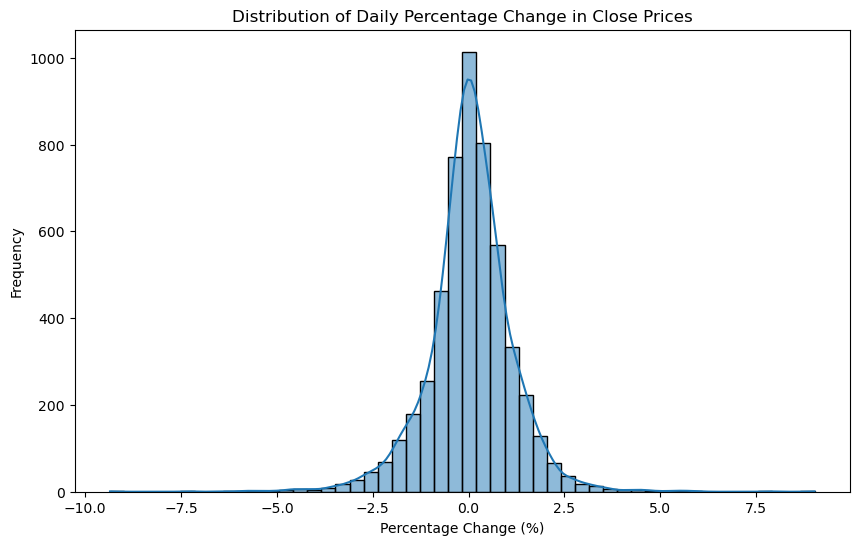

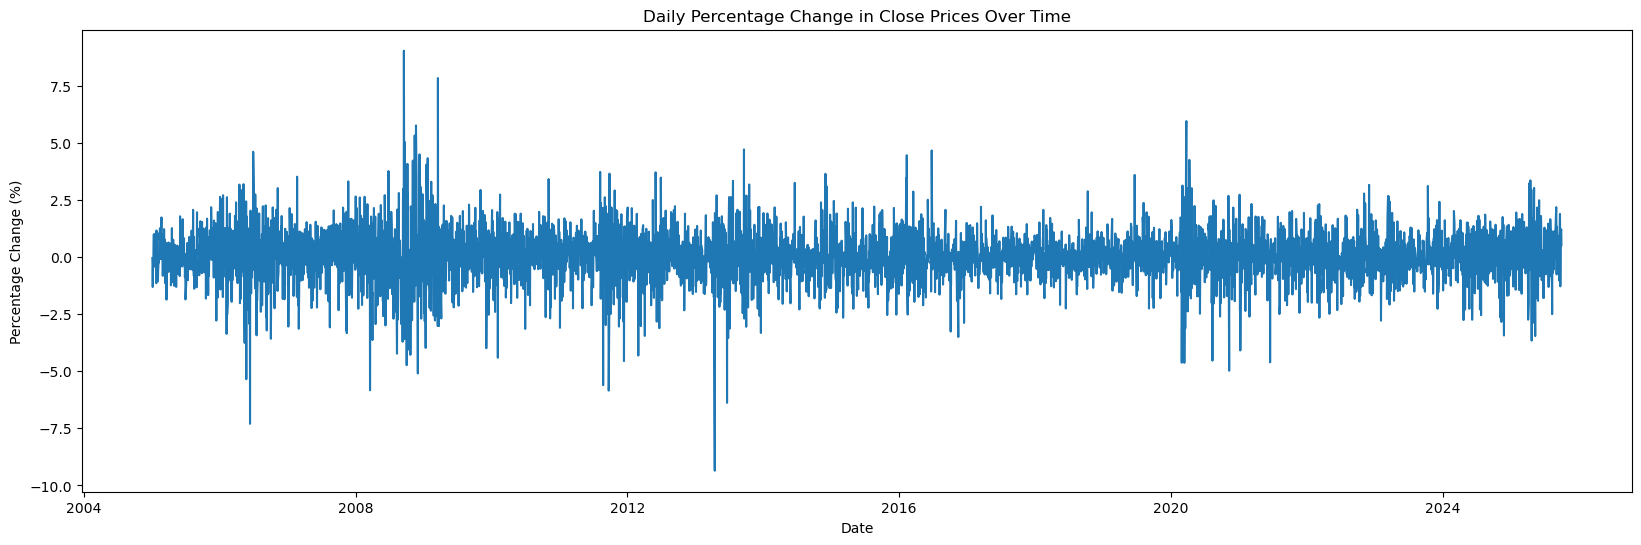

In [5]:
c_trend = TrendAnalyzer(df, base_col='Close')
c_trend.des_trend()
c_trend.plot_trend_dist()
c_trend.plot_trend_over_time()

### Open-Close

               Value
Percentile          
0.0        -9.377781
25.0       -0.430136
50.0        0.000000
75.0        0.355569
90.0        0.993517
95.0        1.521133
99.0        2.790086
99.5        3.381158
99.9        5.231279
100.0       7.955620


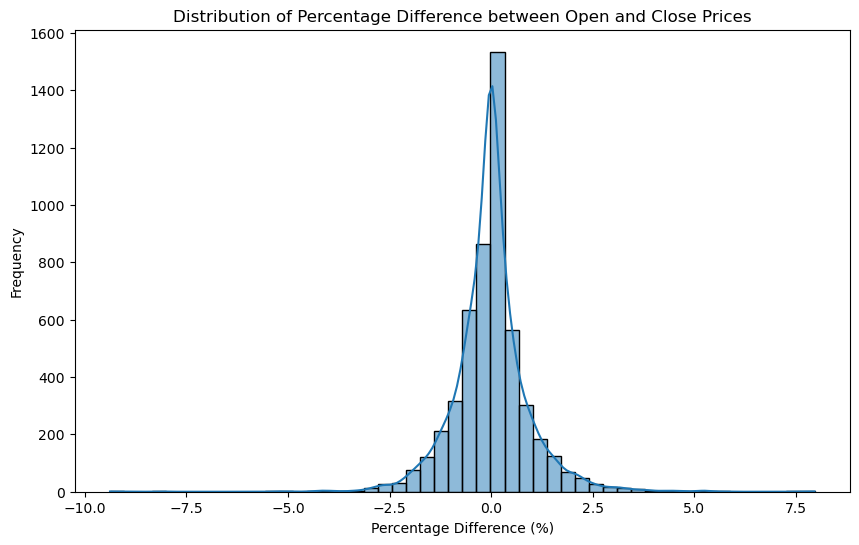

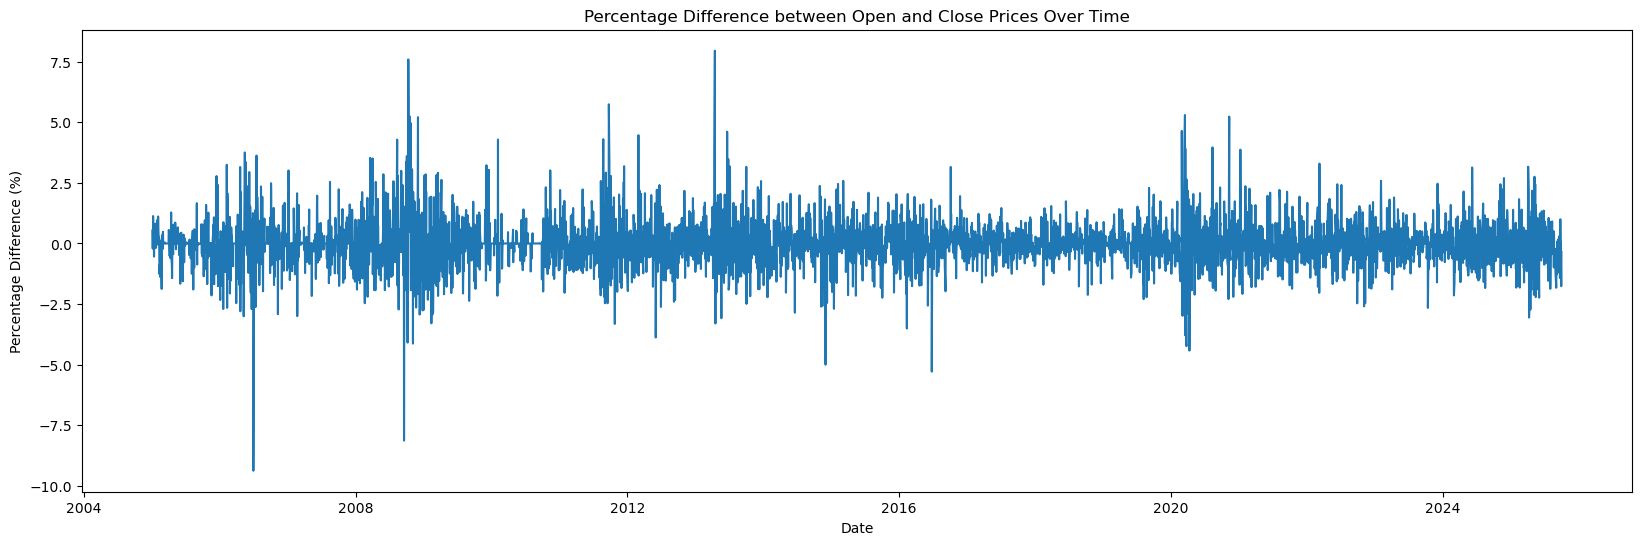

In [6]:
oc = DiffAnalyzer(df, 'Open', 'Close')
oc.des_diff()
oc.plot_diff_dist()
oc.plot_diff_trend()

### High-Low

                Value
Percentile           
0.0         -0.111784
25.0         0.438920
50.0         0.848111
75.0         1.391845
90.0         2.095355
95.0         2.595901
99.0         4.179648
99.5         5.255700
99.9         7.146859
100.0       10.044374


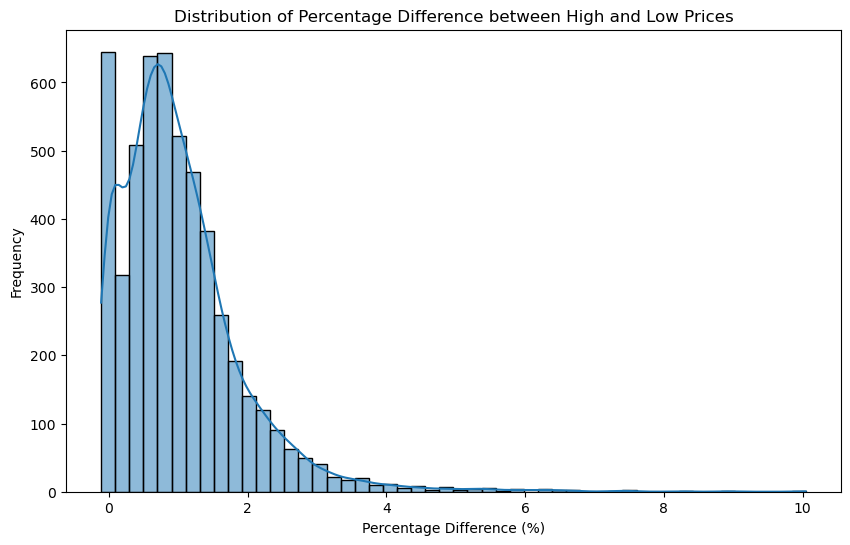

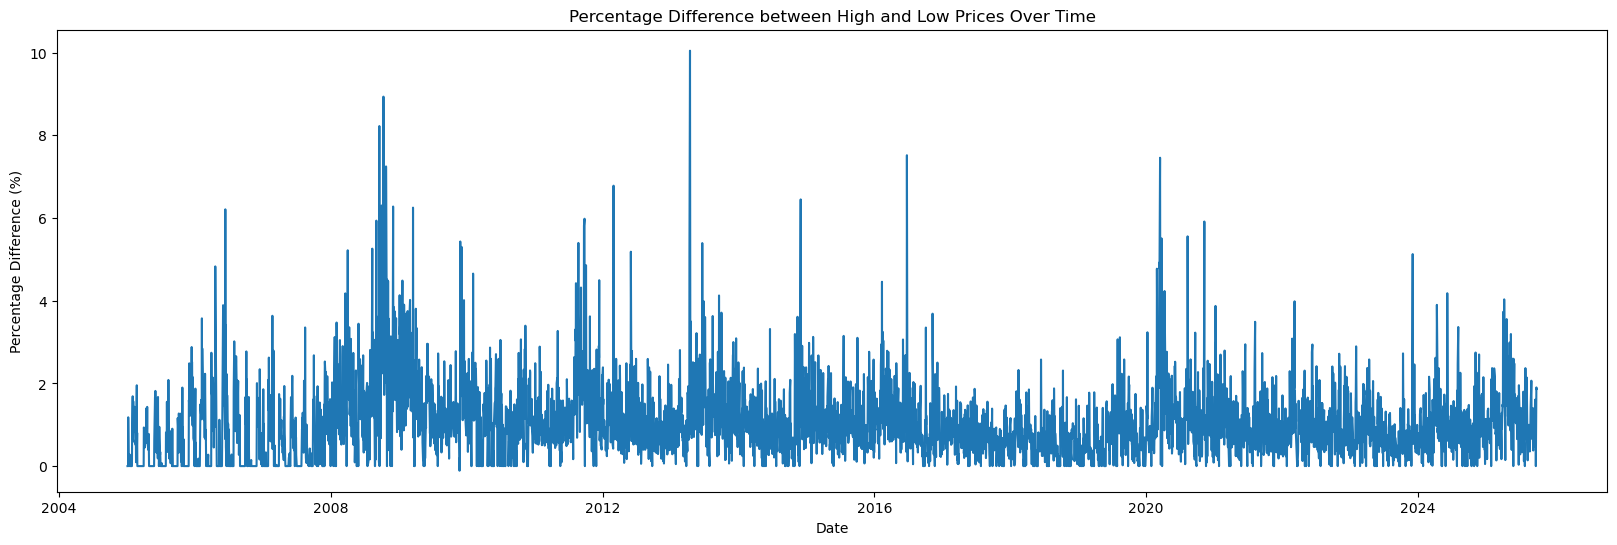

In [7]:
hl = DiffAnalyzer(df, 'High', 'Low')
hl.des_diff()
hl.plot_diff_dist()
hl.plot_diff_trend()

### Open-Low

               Value
Percentile          
0.0        -8.575499
25.0        0.000000
50.0        0.271293
75.0        0.736300
90.0        1.403265
95.0        1.882411
99.0        3.320663
99.5        4.319710
99.9        6.505029
100.0       9.484505


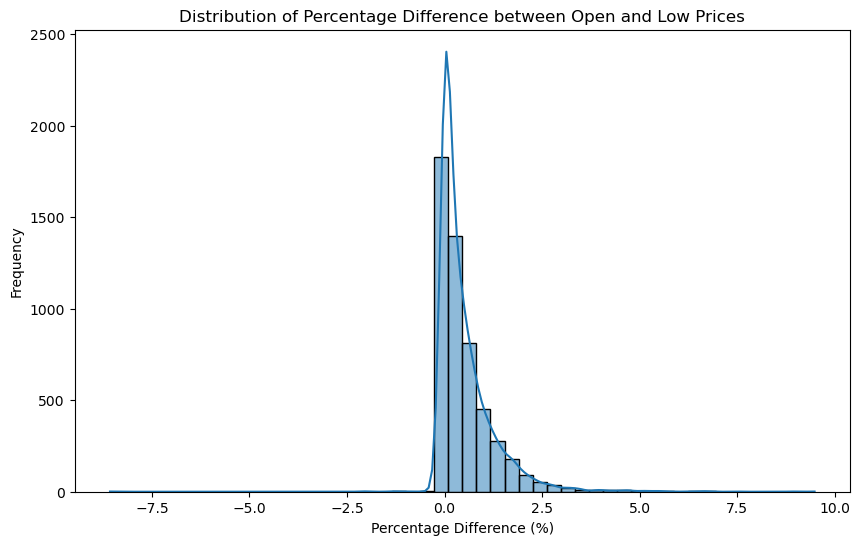

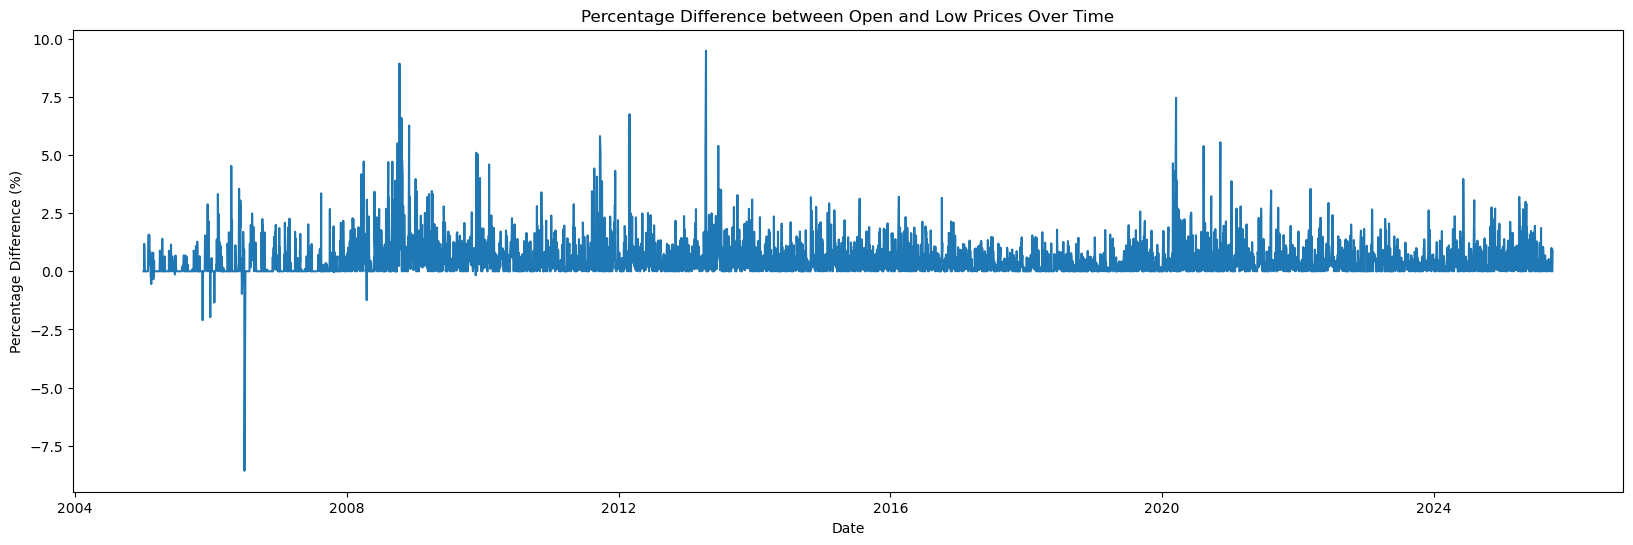

In [8]:
ol = DiffAnalyzer(df, 'Open', 'Low')
ol.des_diff()
ol.plot_diff_dist()
ol.plot_diff_trend()

### Rolling Low

                Value
Percentile           
0.0          0.000000
25.0         0.000000
50.0         0.000000
75.0         0.816357
90.0         1.961316
95.0         2.943867
99.0         5.719642
99.5         7.230145
99.9        11.991740
100.0       15.732484


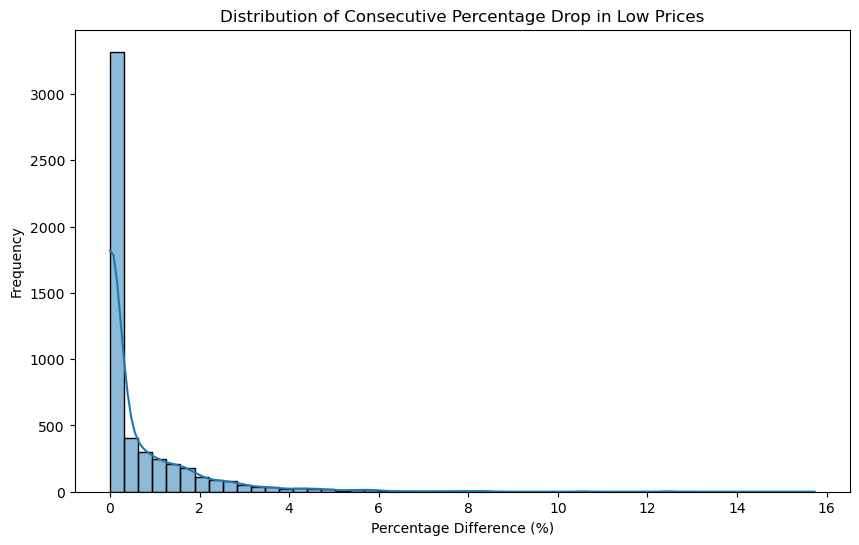

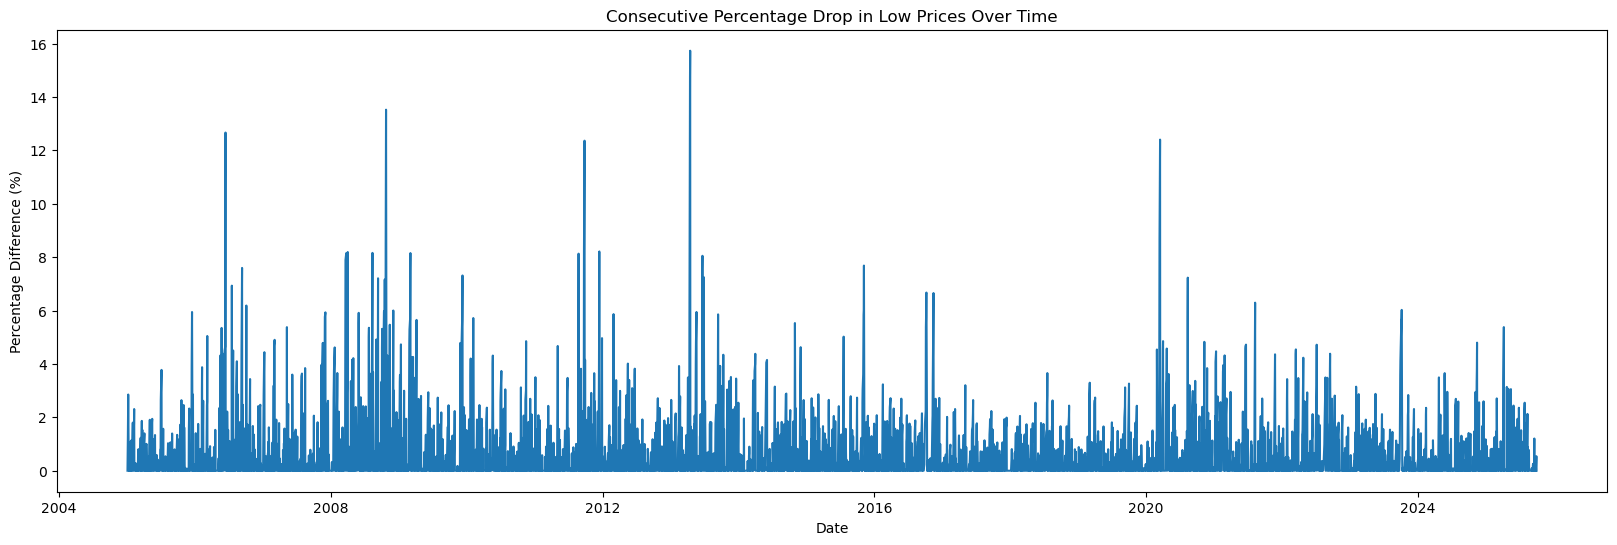

In [9]:
rl = ConDropAnalyzer(df, 'Low')
rl.des_diff()
rl.plot_diff_dist()
rl.plot_diff_trend()

### ATH Dip

                Value
Percentile           
0.0          0.000000
25.0         5.538940
50.0        12.743251
75.0        31.081292
90.0        36.038397
95.0        38.058956
99.0        43.234463
99.5        43.857529
99.9        44.866323
100.0       45.270979


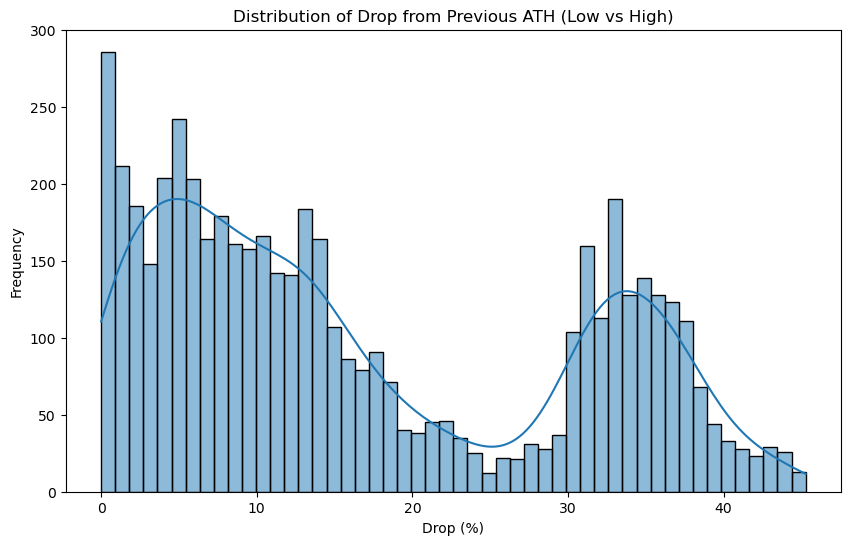

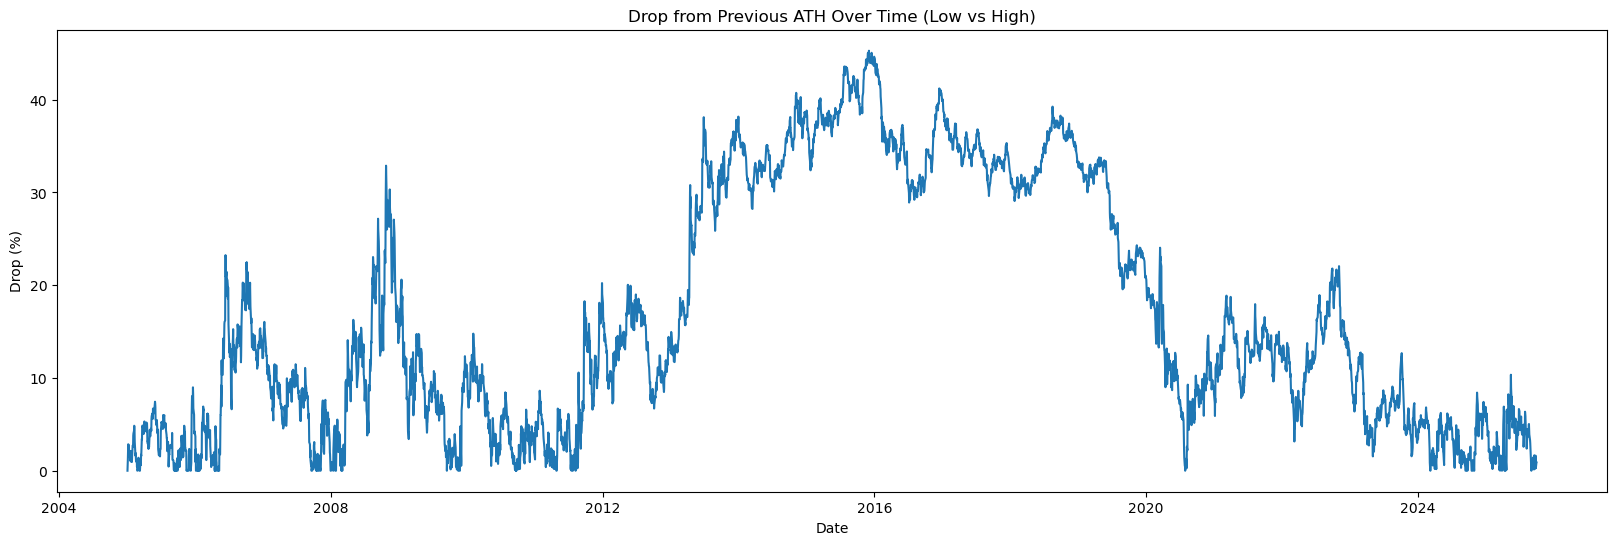

In [10]:
rl = PrevATHDropAnalyzer(df)
rl.des_diff()
rl.plot_diff_dist()
rl.plot_diff_trend()